In [1]:
import torch
import torchaudio
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.utils.prune as prune
from Pipeline import * #comment this for colab and uncomment while submitting
from torchvision import transforms,datasets
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchsummary import summary
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='latin1')
    return dic



def load_cifar10(data_dir, train=True):
    images = []
    labels = []
    if train:
        file_prefix = 'data_batch'
        for batch_file in os.listdir(data_dir):
              if batch_file.startswith('data_batch'):
                  batch_data = unpickle(os.path.join(data_dir, batch_file))
                  images.append(batch_data['data'])
                  labels.append(batch_data['labels'])
        images = np.concatenate(images, axis=0)
        labels = np.concatenate(labels, axis=0)


    else:
        file_prefix = 'test_batch'
        batch_file = os.path.join(data_dir, file_prefix)
        batch_data = unpickle(batch_file)
        images.append(batch_data['data'])
        labels.append(batch_data['labels'])
        images = np.concatenate(images, axis=0)
        labels = np.concatenate(labels, axis=0)


    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels






def read_file_paths(file_path,root):
    with open(file_path, 'r') as f:
        file_paths = f.readlines()
    file_paths = [os.path.join(root,path.strip()) for path in file_paths]
    return file_paths



def find_checkpoint_dir(network,dataloader):
    Type="image"
    if isinstance(network, Resnet_Q1):
        checkpoint_dir="./checkpoints/Resnet_Q1/"
        if isinstance(dataloader.dataset,ImageDataset):
            checkpoint_dir+="image/"
        elif isinstance(dataloader.dataset,AudioDataset):
            checkpoint_dir+="audio/"
            Type="audio"
        else: print("check_dir error")

    elif isinstance(network, VGG_Q2):
        checkpoint_dir="./checkpoints/VGG_Q2/"
        if isinstance(dataloader.dataset,ImageDataset):
            checkpoint_dir+="image/"
        elif isinstance(dataloader.dataset,AudioDataset):
            checkpoint_dir+="audio/"
            Type="audio"
        else: print("check_dir error")

    elif isinstance(network, Inception_Q3):
        checkpoint_dir="./checkpoints/Inception_Q3/"
        if isinstance(dataloader.dataset,ImageDataset):
            checkpoint_dir+="image/"
        elif isinstance(dataloader.dataset,AudioDataset):
            checkpoint_dir+="audio/"
            Type="audio"
        else: print("check_dir error")

    elif isinstance(network, CustomNetwork_Q4):
        checkpoint_dir="./checkpoints/CustomNetwork_Q4/"
        if isinstance(dataloader.dataset,ImageDataset):
            checkpoint_dir+="image/"
        elif isinstance(dataloader.dataset,AudioDataset):
            checkpoint_dir+="audio/"
            Type="audio"
        else: print("check_dir error")

    else: print("check_dir error")
    return checkpoint_dir,Type





def get_audio_network(network):

    if isinstance(network, Resnet_Q1):
        net=Resnet_Q1(Type='audio')

    elif isinstance(network, VGG_Q2):
        net=VGG_Q2(Type='audio')

    elif isinstance(network, Inception_Q3):
         net=Inception_Q3(Type='audio')


    elif isinstance(network, CustomNetwork_Q4):
        net=CustomNetwork_Q4(Type='audio')

    else: print("check_dir error")
    return net

Downloading and preprocessing IMAGE and AUDIO DATA

In [2]:
# IMAGE-  CIFAR-10 dataset
image_label_to_name= {0: ('airplane', 0), 1: ('automobile', 1), 2: ('bird', 2), 3: ('cat', 3), 4: ('deer', 4), 5: ('dog', 5), 6: ('frog', 6), 7: ('horse', 7), 8: ('ship', 8), 9: ('truck', 9)}

transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_directory = "./data/cifar-10-batches-py"
if os.path.exists(data_directory):
    pass
else:
    image_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_image)
    image_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_image)


train_images, train_labels = load_cifar10(data_directory, train=True)
test_images, test_labels = load_cifar10(data_directory, train=False)
train_size = 40000
val_size = 10000
image_train_data, image_val_data, image_train_labels, image_val_labels = train_test_split(train_images, train_labels, test_size=10000, random_state=42)
image_test_data,image_test_labels=test_images,test_labels

image_datasets_dict={"train":[image_train_data,image_train_labels],"val":[image_val_data,image_val_labels],"test":[image_test_data,image_test_labels]}


100%|██████████| 170498071/170498071 [00:01<00:00, 90010682.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Audio- Speech command dataset v0.02
audio_label_to_name={0: 'backward', 1: 'bed', 2: 'bird', 3: 'cat', 4: 'dog', 5: 'down', 6: 'eight', 7: 'five', 8: 'follow', 9: 'forward', 10: 'four', 11: 'go', 12: 'happy', 13: 'house', 14: 'learn', 15: 'left', 16: 'marvin', 17: 'nine', 18: 'no', 19: 'off', 20: 'on', 21: 'one', 22: 'right', 23: 'seven', 24: 'sheila', 25: 'six', 26: 'stop', 27: 'three', 28: 'tree', 29: 'two', 30: 'up', 31: 'visual', 32: 'wow', 33: 'yes', 34: 'zero'}
audio_name_to_label={'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


transform_audio =  torchaudio.transforms.Resample(orig_freq=16000, new_freq=8000)

data_directory = "./data/speech_commands"
if os.path.exists(data_directory): speech_commands_dataset = SPEECHCOMMANDS(root=data_directory, download=False)
else:
    os.makedirs("./data", exist_ok=True)
    speech_commands_dataset = SPEECHCOMMANDS(root="./data", download=True)

100%|██████████| 2.26G/2.26G [00:22<00:00, 107MB/s]


In [4]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, transform=None,speech_commands_dataset=None):
        self.dataset = speech_commands_dataset
        self.transform = transform
        self.max_length = 16000

    def __getitem__(self, index):
        waveform, sample_rate, label, speaker_id, utterance_number = self.dataset[index]

        if self.max_length is not None:
            waveform_len = waveform.shape[-1]
            if waveform_len < self.max_length:
                padding = torch.zeros((1, self.max_length - waveform_len))
                waveform = torch.cat((waveform, padding), dim=-1)

        if self.transform:
           waveform = self.transform(waveform)

        waveform = self.normalize_audio(waveform)
        return waveform, audio_name_to_label[label]



    def __len__(self):
        return len(self.dataset)


    def normalize_audio(self, waveform):
        max_val = waveform.abs().max()
        if max_val > 0:
            normalized_waveform = waveform / max_val
        else:
            normalized_waveform = waveform
        return normalized_waveform




dataset_size = len(speech_commands_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size



# Assuming train_size, val_size, and test_size are predefined
audio_train_set, audio_val_set, audio_test_set = random_split(SpeechCommandsDataset(transform=transform_audio,speech_commands_dataset=speech_commands_dataset),[train_size, val_size, test_size])
audio_datasets_dict={"train":audio_train_set,"val":audio_val_set,"test":audio_test_set}


for dataset in audio_datasets_dict:
    preprocessed_data = []
    for i in range(0,len(audio_datasets_dict[dataset])):
        preprocessed_data.append(audio_datasets_dict[dataset][i])
    audio_datasets_dict[dataset]=preprocessed_data

In [6]:
class ImageDataset(Dataset):
    def __init__(self, split:str="train") -> None:
        super().__init__()
        if split not in ["train", "test", "val"]:
            raise Exception("Data split must be in [train, test, val]")

        self.datasplit = split
        self.images=image_datasets_dict[split][0]
        self.labels=image_datasets_dict[split][1]
        self.transform=transform_image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image=self.images[idx]
        if self.transform is not None:
            image = self.transform(image)
        label=self.labels[idx]
        return (image, label)




class AudioDataset(Dataset):
    def __init__(self, split:str="train") -> None:
        super().__init__()
        if split not in ["train", "test", "val"]:
            raise Exception("Data split must be in [train, test, val]")

        self.datasplit = split
        self.dataset=audio_datasets_dict[split]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


<br><br><br>
<h3> Visualize Images </h3>

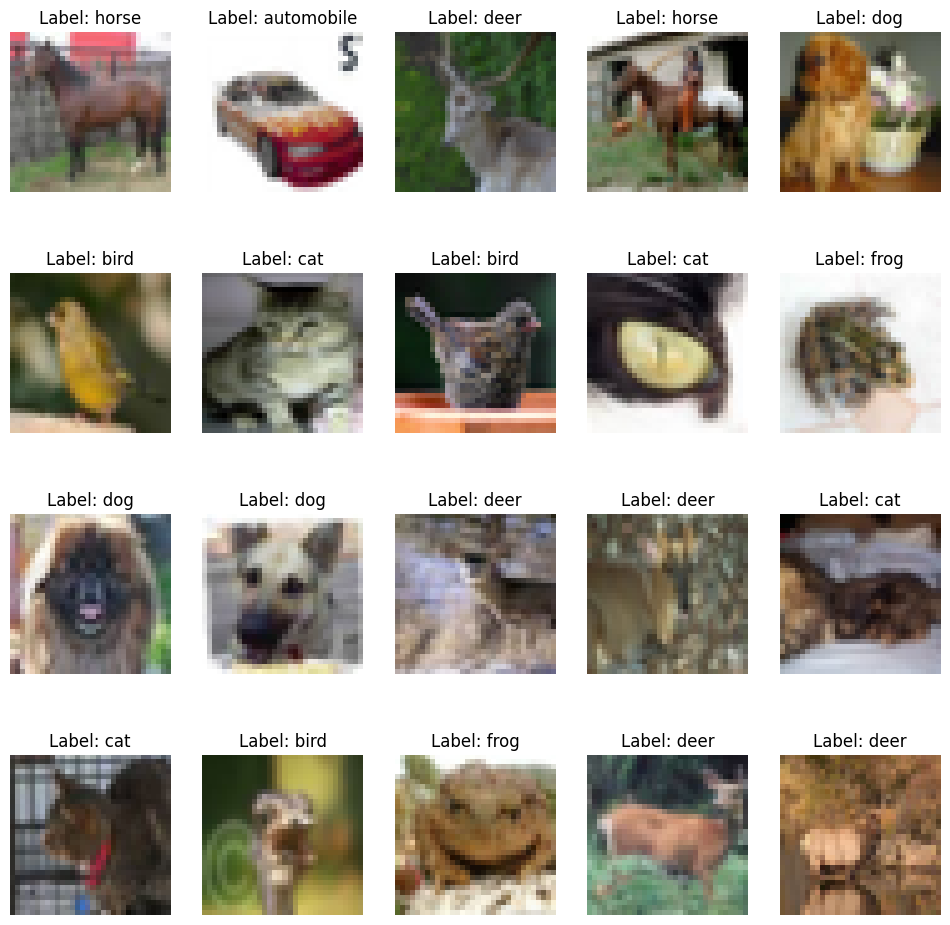

In [ ]:
def display_random_images(image_train_data,image_train_labels):
    num_images_to_display = 20
    num_rows = 4
    num_cols = num_images_to_display // num_rows

    random_indices = torch.randperm(len(image_train_data))[:num_images_to_display]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = random_indices[i * num_cols + j]
            image= image_train_data[index]
            label= image_train_labels[index]
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].set_title(f'Label: {image_label_to_name[label][0]}')
            axes[i, j].axis('off')
    plt.show()




display_random_images(image_train_data,image_train_labels)

RESNET

In [7]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1,Type="",ker1_size=3,ker2_size=3):
        super(BasicBlock, self).__init__()
        pad1=(ker1_size-1)//2
        pad2=(ker2_size-1)//2
        if (Type=="image"):
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=ker1_size, stride=stride, padding=pad1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=ker2_size, stride=1, padding=pad2, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU()

            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )


        elif (Type=="audio"):
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=ker1_size, stride=stride, padding=pad1, bias=False)
            self.bn1 = nn.BatchNorm1d(out_channels)
            self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=ker2_size, stride=1, padding=pad2, bias=False)
            self.bn2 = nn.BatchNorm1d(out_channels)
            self.relu = nn.ReLU()

            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm1d(out_channels)
                )

        else:
            print('FATAL ERROR')



    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out





class Resnet_Q1(nn.Module):
    def __init__(self, num_classes=10,Type="image") -> None:
        super().__init__()
        num_blocks=[6,6,6]

        if Type=="image":
            self.in_channels = 3
            self.layer1 = self._make_layer(64, num_blocks[0],2,Type)
            self.layer2 = self._make_layer(128, num_blocks[1],2,Type)
            self.layer3 = self._make_layer(256, num_blocks[2],2,Type)

            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.linear = nn.Linear(256, num_classes)


        elif Type=="audio":
            num_blocks=[6,6,6]
            num_classes=35
            self.in_channels = 1
            self.layer1 = self._make_layer(16, num_blocks[0],2,Type)
            self.layer2 = self._make_layer(32, num_blocks[1],2,Type)
            self.layer3 = self._make_layer(64, num_blocks[2],2,Type)

            self.linear = nn.Linear(64, num_classes)

        self.relu=nn.ReLU()




    def _make_layer(self, out_channels, num_blocks, stride,Type):
        strides = [stride]*num_blocks
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride,Type))
            self.in_channels = out_channels
        return nn.Sequential(*layers)



    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


VGG

In [8]:
class VGG_Q2(nn.Module):
    def __init__(self, num_classes=10,Type="image") -> None:
        super().__init__()
        self.Type=Type
        if Type=="image":

            # Block 1
            # 284-> 184-> 119-> 77-> 50->       linear layer->64------
            self.conv1_1 = nn.Conv2d(3, 129, kernel_size=3, padding=1)
            self.bn1_1 = nn.BatchNorm2d(129)
            self.conv1_2 = nn.Conv2d(129, 129, kernel_size=3, padding=1)
            self.bn1_2 = nn.BatchNorm2d(129)
            self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)

            # Block 2
            self.conv2_1 = nn.Conv2d(129, 84, kernel_size=5, padding=2)
            self.bn2_1 = nn.BatchNorm2d(84)
            self.conv2_2 = nn.Conv2d(84, 84, kernel_size=5, padding=2)
            self.bn2_2 = nn.BatchNorm2d(84)
            self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)

            # Block 3
            self.conv3_1 = nn.Conv2d(84, 55, kernel_size=7, padding=3)
            self.bn3_1 = nn.BatchNorm2d(55)
            self.conv3_2 = nn.Conv2d(55, 55, kernel_size=7, padding=3)
            self.bn3_2 = nn.BatchNorm2d(55)
            self.conv3_3 = nn.Conv2d(55, 55, kernel_size=7, padding=3)
            self.bn3_3 = nn.BatchNorm2d(55)
            self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)

            # Block 4
            self.conv4_1 = nn.Conv2d(55, 36, kernel_size=9, padding=4)
            self.bn4_1 = nn.BatchNorm2d(36)
            self.conv4_2 = nn.Conv2d(36, 36, kernel_size=9, padding=4)
            self.bn4_2 = nn.BatchNorm2d(36)
            self.conv4_3 = nn.Conv2d(36, 36, kernel_size=9, padding=4)
            self.bn4_3 = nn.BatchNorm2d(36)
            self.pool4 = nn.MaxPool2d(kernel_size=3, stride=1)

            # Block 5
            self.conv5_1 = nn.Conv2d(36, 24, kernel_size=11, padding=5)
            self.bn5_1 = nn.BatchNorm2d(24)
            self.conv5_2 = nn.Conv2d(24, 24, kernel_size=11, padding=5)
            self.bn5_2 = nn.BatchNorm2d(24)
            self.conv5_3 = nn.Conv2d(24, 24, kernel_size=11, padding=5)
            self.bn5_3 = nn.BatchNorm2d(24)
            self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1)


            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

            # Fully connected layers
            self.fc1 = nn.Linear(24, 64)  # Adjusted input size after pooling
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, num_classes)


            self.relu = nn.ReLU()




        elif Type=="audio":
            num_classes=35

            # 284-> 184-> 119-> 77-> 50->       linear layer->64------
            self.conv1_1 = nn.Conv1d(1, 129, kernel_size=3, padding=1)
            self.bn1_1 = nn.BatchNorm1d(129)
            self.conv1_2 = nn.Conv1d(129, 129, kernel_size=3, padding=1)
            self.bn1_2 = nn.BatchNorm1d(129)
            self.pool1 = nn.MaxPool1d(kernel_size=3, stride=3)

            # Block 2
            self.conv2_1 = nn.Conv1d(129, 84, kernel_size=5, padding=2)
            self.bn2_1 = nn.BatchNorm1d(84)
            self.conv2_2 = nn.Conv1d(84, 84, kernel_size=5, padding=2)
            self.bn2_2 = nn.BatchNorm1d(84)
            self.pool2 = nn.MaxPool1d(kernel_size=3, stride=3)

            # Block 3
            self.conv3_1 = nn.Conv1d(84, 55, kernel_size=7, padding=3)
            self.bn3_1 = nn.BatchNorm1d(55)
            self.conv3_2 = nn.Conv1d(55, 55, kernel_size=7, padding=3)
            self.bn3_2 = nn.BatchNorm1d(55)
            self.conv3_3 = nn.Conv1d(55, 55, kernel_size=7, padding=3)
            self.bn3_3 = nn.BatchNorm1d(55)
            self.pool3 = nn.MaxPool1d(kernel_size=3, stride=3)

            # Block 4
            self.conv4_1 = nn.Conv1d(55, 36, kernel_size=9, padding=4)
            self.bn4_1 = nn.BatchNorm1d(36)
            self.conv4_2 = nn.Conv1d(36, 36, kernel_size=9, padding=4)
            self.bn4_2 = nn.BatchNorm1d(36)
            self.conv4_3 = nn.Conv1d(36, 36, kernel_size=9, padding=4)
            self.bn4_3 = nn.BatchNorm1d(36)
            self.pool4 = nn.MaxPool1d(kernel_size=3, stride=3)

            # Block 5
            self.conv5_1 = nn.Conv1d(36, 24, kernel_size=11, padding=5)
            self.bn5_1 = nn.BatchNorm1d(24)
            self.conv5_2 = nn.Conv1d(24, 24, kernel_size=11, padding=5)
            self.bn5_2 = nn.BatchNorm1d(24)
            self.conv5_3 = nn.Conv1d(24, 24, kernel_size=11, padding=5)
            self.bn5_3 = nn.BatchNorm1d(24)
            self.pool5 = nn.MaxPool1d(kernel_size=3, stride=3) #-> 100

            self.avgpool = nn.AdaptiveAvgPool1d(1)


            # Fully connected layers
            self.fc1 = nn.Linear(24, 64)  # Adjusted input size after pooling
            self.fc2 = nn.Linear(64, 128)
            self.fc3 = nn.Linear(128, num_classes)
            self.relu = nn.ReLU()





    def forward(self, x):
          x = F.relu(self.bn1_1(self.conv1_1(x)))
          x = F.relu(self.bn1_2(self.conv1_2(x)))
          x = self.pool1(x)

          x = F.relu(self.bn2_1(self.conv2_1(x)))
          x = F.relu(self.bn2_2(self.conv2_2(x)))
          x = self.pool2(x)

          x = F.relu(self.bn3_1(self.conv3_1(x)))
          x = F.relu(self.bn3_2(self.conv3_2(x)))
          x = F.relu(self.bn3_3(self.conv3_3(x)))
          x = self.pool3(x)

          x = F.relu(self.bn4_1(self.conv4_1(x)))
          x = F.relu(self.bn4_2(self.conv4_2(x)))
          x = F.relu(self.bn4_3(self.conv4_3(x)))
          x = self.pool4(x)

          x = F.relu(self.bn5_1(self.conv5_1(x)))
          x = F.relu(self.bn5_2(self.conv5_2(x)))
          x = F.relu(self.bn5_3(self.conv5_3(x)))
          x = self.pool5(x)

          x=self.avgpool(x)

          x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

INCEPTION (GOOGLE NET)

In [9]:
class InceptionBlock(nn.Module):

    def __init__(self,in_channels,out1_1,out2_1,out2_2,out3_1,out3_2,pool_proj,Type="",ker1_1=1,ker2_1=3,ker2_2=5,ker4_1=3):
        super().__init__()


        if Type=="image":
          # input(3,32,32)

            # 1X1 CNA
            self.branch1 = nn.Sequential(
                nn.Conv2d(in_channels, out1_1, kernel_size=ker1_1),
                nn.BatchNorm2d(out1_1),
                nn.ReLU(inplace=True)
            )


            # 3X3 AND 5X5 CNA- 1
            self.branch2 = nn.Sequential(
                nn.Conv2d(in_channels,out2_1,kernel_size=ker2_1,padding=1),
                nn.BatchNorm2d(out2_1),
                nn.ReLU(inplace=True),

                nn.Conv2d(out2_1,out2_2,kernel_size=ker2_2,padding=2),
                nn.BatchNorm2d(out2_2),
                nn.ReLU(inplace=True)
            )


            # 3X3 AND 5X5 CNA- 2
            self.branch3 = nn.Sequential(
                nn.Conv2d(in_channels,out3_1,kernel_size=ker2_1,padding=1),
                nn.BatchNorm2d(out3_1),
                nn.ReLU(inplace=True),

                nn.Conv2d(out3_1,out3_2,kernel_size=ker2_2,padding=2),
                nn.BatchNorm2d(out3_2),
                nn.ReLU(inplace=True)
            )


            # 3X3 MAXpool
            self.branch4 = nn.Sequential(
                nn.MaxPool2d(kernel_size=ker4_1,stride=1,padding=1),
                nn.Conv2d(in_channels,pool_proj,kernel_size=1),
            )



        elif Type=="audio":
              # 1X1 CNA
            self.branch1 = nn.Sequential(
                nn.Conv1d(in_channels, out1_1, kernel_size=ker1_1),
                nn.BatchNorm1d(out1_1),
                nn.ReLU(inplace=True)
            )


            # 3X3 AND 5X5 CNA- 1
            self.branch2 = nn.Sequential(
                nn.Conv1d(in_channels,out2_1,kernel_size=ker2_1,padding=1),
                nn.BatchNorm1d(out2_1),
                nn.ReLU(inplace=True),

                nn.Conv1d(out2_1,out2_2,kernel_size=ker2_2,padding=2),
                nn.BatchNorm1d(out2_2),
                nn.ReLU(inplace=True)
            )


            # 3X3 AND 5X5 CNA- 2
            self.branch3 = nn.Sequential(
                nn.Conv1d(in_channels,out3_1,kernel_size=ker2_1,padding=1),
                nn.BatchNorm1d(out3_1),
                nn.ReLU(inplace=True),

                nn.Conv1d(out3_1,out3_2,kernel_size=ker2_2,padding=2),
                nn.BatchNorm1d(out3_2),
                nn.ReLU(inplace=True)
            )


            # 3X3 MAXpool
            self.branch4 = nn.Sequential(
                nn.MaxPool1d(kernel_size=ker4_1,stride=1,padding=1),
                nn.Conv1d(in_channels,pool_proj,kernel_size=1),
            )




    def forward(self,x):

        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1,branch2,branch3,branch4]
        return torch.cat(outputs,1)





class Inception_Q3(nn.Module):
      def __init__(self, num_classes=10,Type="image") -> None:
        super(Inception_Q3,self).__init__()
        self.Type=Type



        if Type=="image":
        # input (3,32,32)

            self.block1 = InceptionBlock(3,4,2,4,2,4,4,Type)                # output (8+8+8+8=32,32,32) -> 16
            self.block2 = InceptionBlock(16,4,2,4,2,4,4,Type)           # output (16+16+16+16=64,32,32) -> 32->16
            self.block3 = InceptionBlock(16,8,4,8,4,8,8,Type)         # output (32+32+32+32=128,32,32) ->64->32
            self.block4 = InceptionBlock(32,16,8,16,8,16,16,Type)        # output (64+64+64+64=256,32,32) -> 128-> 64
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))                # output (256,1,1)
            self.fc = nn.Linear(64, num_classes)


        elif Type=="audio":
            self.block1 = InceptionBlock(1,4,2,4,2,4,4,Type)
            self.block2 = InceptionBlock(16,4,2,4,2,4,4,Type)
            self.block3 = InceptionBlock(16,8,4,8,4,8,8,Type)
            self.block4 = InceptionBlock(32,16,8,16,8,16,16,Type)
            self.maxpool = nn.MaxPool1d(5, stride=4, ceil_mode=True)
            self.avgpool = nn.AdaptiveAvgPool1d(1)
            num_classes=35
            self.fc = nn.Linear(64, num_classes)



      def forward(self, x):

          if self.Type=='image':
              x = self.block1(x)
              x = self.block2(x)
              x = self.block3(x)
              x = self.block4(x)
              x = self.avgpool(x)
              x = x.view(x.size(0), -1)
              x = self.fc(x)

          elif self.Type=='audio':
              x = self.maxpool(x)
              x = self.block1(x)
              x = self.maxpool(x)
              x = self.block2(x)
              x = self.maxpool(x)
              x = self.block3(x)
              x = self.maxpool(x)
              x = self.block4(x)
              x = self.maxpool(x)
              x= self.avgpool(x)
              x = x.view(x.size(0), -1)
              x = self.fc(x)

          return x

# source -  https://github.com/Bryant6/DL_Conv_model/blob/master/classification/GoogLeNet.py

CUSTOM NETWORK

In [17]:
class CustomNetwork_Q4(nn.Module):
      def __init__(self, num_classes=10,Type="image") -> None:
          super().__init__()
          self.Type=Type


          # decreasing channels after every inception pool layer  (128->80->52->32->20)
          # and increasing kernel size after every inception pool layer (3->5->7->9)
          if Type=="image":
              self.in_channels=3
              self.block1 = BasicBlock(self.in_channels,128,1,Type,3,3)
              self.block2 = BasicBlock(128, 128,1,Type,3,3)
              self.block3 = InceptionBlock(128,32,16,32,16,32,32,Type) # 128/4=32
              self.block4 = InceptionBlock(128,20,10,20,10,20,20,Type) # input 128 -- output 80 (80/4=20)
              self.block5 = BasicBlock(80,48,1,Type,5,5) # 80 -> 48
              self.block6 = InceptionBlock(48,12,6,12,6,12,12,Type) # 48/4 = 12
              self.block7 = BasicBlock(48,32,1,Type,7,7)  # 48 -> 32
              self.block8 = InceptionBlock(32,8,4,8,4,8,8,Type) # 32/4=8
              self.block9 = BasicBlock(32,16,1,Type,9,9) #  32->16
              self.block10 = InceptionBlock(16,4,2,4,2,4,4,Type)    # output(16,32,32)


              self.avgpool = nn.AdaptiveAvgPool2d((1, 1))                # output (16,1,1)
              self.fc = nn.Linear(16, num_classes)



          elif Type=="audio":
              num_classes=35
              self.in_channels=1
              self.block1 = BasicBlock(self.in_channels,128,2,Type,3,3)
              self.block2 = BasicBlock(128, 128,2,Type,3,3)
              self.block3 = InceptionBlock(128,32,16,32,16,32,32,Type) # 128/4=32
              self.block4 = InceptionBlock(128,20,10,20,10,20,20,Type) # input 128 -- output 80 (80/4=20)
              self.block5 = BasicBlock(80,48,2,Type,5,5) # 80 -> 48
              self.block6 = InceptionBlock(48,12,6,12,6,12,12,Type) # 48/4 = 12
              self.block7 = BasicBlock(48,32,2,Type,7,7)  # 48 -> 32
              self.block8 = InceptionBlock(32,8,4,8,4,8,8,Type) # 32/4=8
              self.block9 = BasicBlock(32,16,2,Type,9,9) #  32->16
              self.block10 = InceptionBlock(16,4,2,4,2,4,4,Type)  # output(16,7)

              self.maxpool = nn.MaxPool1d(3, stride=2, ceil_mode=True)

              self.avgpool = nn.AdaptiveAvgPool1d(1)                # output (16,1)
              self.fc = nn.Linear(16, num_classes)




      def forward(self, x):

          if self.Type=='image':
              x= self.block1(x)
              x= self.block2(x)
              x = self.block3(x)
              x = self.block4(x)
              x= self.block5(x)
              x = self.block6(x)
              x= self.block7(x)
              x = self.block8(x)
              x= self.block9(x)
              x = self.block10(x)

              x = self.avgpool(x)
              x = x.view(x.size(0), -1)
              x = self.fc(x)

          elif self.Type=='audio':
              x = self.maxpool(self.block1(x))
              x = self.maxpool(self.block2(x))
              x = self.block3(x)
              x = self.block4(x)
              x = self.maxpool(self.block5(x))
              x = self.block6(x)
              x = self.maxpool(self.block7(x))
              x = self.block8(x)
              x = self.maxpool(self.block9(x))
              x = self.block10(x)

              x = self.avgpool(x)
              x = x.view(x.size(0), -1)
              x = self.fc(x)


          return x


In [12]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCH = 64

MAIN CODE

In [13]:
max_acc_epoch=0
new_network=None

def trainer(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None,val_dataloader=None):

    global max_acc_epoch, new_network
    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    os.makedirs(os.path.dirname(checkpoint_dir), exist_ok=True)


     # if audio network create one - default is image
    if Type=="audio":
       network=get_audio_network(network)
       new_network=network
       optimizer = torch.optim.Adam(params=network.parameters(),lr=LEARNING_RATE)



    accuracies=[]
    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    if gpu=='T': network = network.to(device)




    for epoch in range(EPOCH):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in dataloader:

            if gpu=='T':
                inputs = inputs.to(device)
                labels = labels.to(device)

            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss = total_loss/len(dataloader)
        accuracy = correct / total
        print("Training Epoch: {}, [Loss: {}, Accuracy: {}]".format(epoch+1,loss,accuracy))
        accuracies.append(accuracy)


        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_dir+f'checkpoint_epoch_{epoch+1}.pt')


    max_acc_epoch=accuracies.index(max(accuracies))+1






def validator(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None):


    global new_network
    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    checkpoint=torch.load(checkpoint_dir+f"checkpoint_epoch_{max_acc_epoch}.pt")
    criterion = nn.CrossEntropyLoss()

    if Type=='audio':
       network=new_network
    network.load_state_dict(checkpoint['model_state_dict'])


    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    if gpu=='T':
        network = network.to(device)
        optimizer = torch.optim.Adam(params=network.parameters(),lr=LEARNING_RATE)



    # Write your code here
    for epoch in range(EPOCH):

        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad(): # autograd stops gradient computation to yield faster results
            for val_inputs, val_labels in dataloader:

                if gpu=='T':
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)

                val_outputs = network(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        loss = val_loss/len(dataloader)
        accuracy = val_correct / val_total

        print("Validation Epoch: {}, [Loss: {}, Accuracy: {}]".format(epoch+1,loss,accuracy))






def evaluator(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None):


    global new_network
    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    checkpoint=torch.load(checkpoint_dir+f"checkpoint_epoch_{max_acc_epoch}.pt")
    criterion = nn.CrossEntropyLoss()

    if Type=='audio':
       network=new_network
    network.load_state_dict(checkpoint['model_state_dict'])


    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    if gpu=='T':
        network = network.to(device)
        optimizer = torch.optim.Adam(params=network.parameters(),lr=LEARNING_RATE)



    # Write your code here
    for epoch in range(EPOCH):
        test_loss,test_correct,test_total=0,0,0

        with torch.no_grad():
            for test_inputs, test_labels in dataloader:

                if gpu=='T':
                    test_inputs = test_inputs.to(device)
                    test_labels = test_labels.to(device)

                test_outputs = network(test_inputs)
                test_loss += criterion(test_outputs, test_labels).item()
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()

        loss = test_loss/len(dataloader)
        accuracy = test_correct / test_total

        print("[Loss: {}, Accuracy: {}]".format(loss,accuracy))



In [ ]:
# Replace changerollno with your rollnumber as mentioned in Assignment Guidelines
# import argparse
# import importlib
# from Pipeline import *

# # Dynamically import the module
# module = importlib.import_module("Pipeline.2021452A2")


# P = argparse.ArgumentParser()
# P.add_argument("gpu", type=str)
# A = P.parse_args()




if __name__ == "__main__":

    imageDataset = [
        ImageDataset(split="train"),
        ImageDataset(split="val"),
        ImageDataset(split="test")

    ]

    audioDataset = [
        AudioDataset(split="train"),
        AudioDataset(split="val"),
        AudioDataset(split="test")
    ]

    Architectures = [
        Resnet_Q1(),
        VGG_Q2(),
        Inception_Q3(),
        CustomNetwork_Q4()
    ]


    for network in Architectures:

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            params=network.parameters(),
            lr=LEARNING_RATE
        )

        for dataset in imageDataset + audioDataset:
            if dataset.datasplit == "train":
                print(
                    "Training {} Architecture on {} split of {}".format(
                        network.__class__.__name__,
                        dataset.datasplit,
                        dataset.__class__.__name__
                    )
                )
                network.train()
                train_dataloader = DataLoader(
                    dataset=dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=2,
                    drop_last=True
                )

                trainer(
                    gpu=A.gpu,
                    dataloader=train_dataloader,
                    network=network,
                    criterion=criterion,
                    optimizer=optimizer
                )

            elif dataset.datasplit == "val":
                print(
                    "Validating {} Architecture on {} split of {}".format(
                        network.__class__.__name__,
                        dataset.datasplit,
                        dataset.__class__.__name__
                    )
                )
                network.train()
                val_dataloader = DataLoader(
                    dataset=dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=2,
                    drop_last=True
                )

                validator(
                    gpu=A.gpu,
                    dataloader=val_dataloader,
                    network=network,
                    criterion=criterion,
                    optimizer=optimizer
                )

            elif dataset.datasplit == "test":
                print(
                    "Testing {} Architecture on {} split of {}".format(
                        network.__class__.__name__,
                        dataset.datasplit,
                        dataset.__class__.__name__
                    )
                )
                network.eval()
                test_dataloader = DataLoader(
                    dataset=dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=2,
                    drop_last=True
                )
                evaluator(
                    gpu=A.gpu,
                    dataloader=test_dataloader,
                    network=network,
                    criterion=None,
                    optimizer=None)
